In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.io import read_image, ImageReadMode, write_video
import torchvision.transforms as T
from random import randint
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pylab as pl
from importlib import reload  

from scripts import *
from CAModel import *

In [2]:
N_CHANNELS = 16        # Number of CA state channels
TARGET_PADDING = 16    # Number of pixels used to pad the target image border
TARGET_SIZE = 40       # Size of the target emoji
IMAGE_SIZE = TARGET_PADDING+TARGET_SIZE
BATCH_SIZE = 4
N_ITERS = 50           # Iterations before applying the loss
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

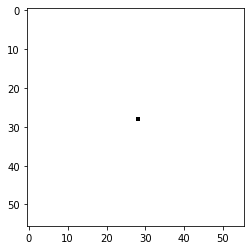

In [3]:
# Starting state
pool = SamplePool(POOL_SIZE, N_CHANNELS, IMAGE_SIZE)
imshow(pool[0][0])

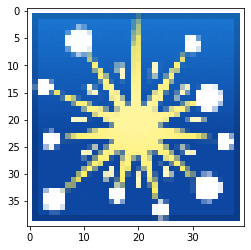

In [4]:
# Imports the target emoji
target = read_image("firework.png", ImageReadMode.RGB_ALPHA).float()
target = T.Resize((TARGET_SIZE, TARGET_SIZE))(target)
target = RGBAtoFloat(target)

imshow(target)

In [5]:
# Custom loss function
class loss_fn:
    """Custom l2 or l1 loss function"""
    def __init__(self, target, order=2):
        self.order = order
        self.target = target
        
    def __call__(self, x):
        losses = torch.mean(torch.abs(x[:, :4, :, :] - self.target)**self.order, [1,2,3])
        idx_max_loss = torch.argmax(losses)
        loss = torch.mean(losses)
        return loss, idx_max_loss

target = target.cpu()
loss_fn(pad(target, TARGET_PADDING), 1)(pool.sample(16)[0])

(tensor(0.2883), tensor(0))

In [6]:
# Define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

target = target.to(device)

In [7]:
# loads a pretrained model
old_CA = CAModel().to(device)
old_CA.load("not_persistent.pt")

Successfully loaded model!


In [8]:
new_CA = CAModel().to(device)
new_CA.load("not_persistent.pt")

Successfully loaded model!


In [9]:
from double_CA import DoubleCA
model = DoubleCA(old_CA, new_CA)

In [63]:
# Train the model

#for param in model.old_CA.parameters():
#    param.requires_grad = False

#optimizer = torch.optim.Adam(model.new_CA.parameters())
#criterion = loss_fn(pad(target, TARGET_PADDING), order=2)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000,20000,30000], gamma=0.2)
#losses = []
for i in range(10000):
    inputs, indexes = pool.sample(BATCH_SIZE)
    inputs = inputs.to(device)
    optimizer.zero_grad()
    
    model.update_cell_masks(inputs)
    for j in range(N_ITERS+randint(-10, 10)):
        inputs = model(inputs)
        
    loss, idx_max_loss = criterion(inputs)
    loss.backward()
    optimizer.step()
    scheduler.step()
    losses.append(loss.item())
    pool.update(inputs.detach().cpu(), indexes, idx_max_loss)

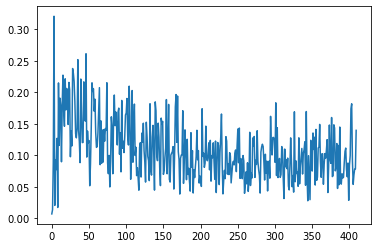

In [64]:
pl.plot(losses[::100])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


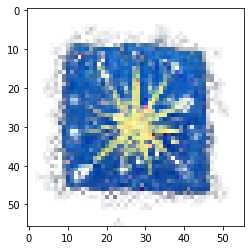

In [86]:
imshow(pool.sample(1)[0][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


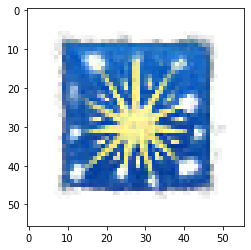

In [17]:
# Plots the learned CA
x, _ = pool.sample(1)
x = x.to(device)
x = model.evolve(x, N_ITERS)

imshow(x[0])

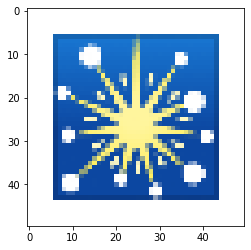

In [21]:
# Plots the true emoji
imshow(TraintoFloat(pad(target, 10, -1)))